In [2]:
import tellurium as te
te.setDefaultPlottingEngine('matplotlib')
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import simulate
import numpy as np
import seaborn as sns
sns.set_style("ticks")
import matplotlib.gridspec as gridspec
import FigureTools as FT


### Plot volume and HOG pathway:

500.0
6000
4200
500.0
500.0
500.0
4200
6000


/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



325.0
500.0
500.0
325.0


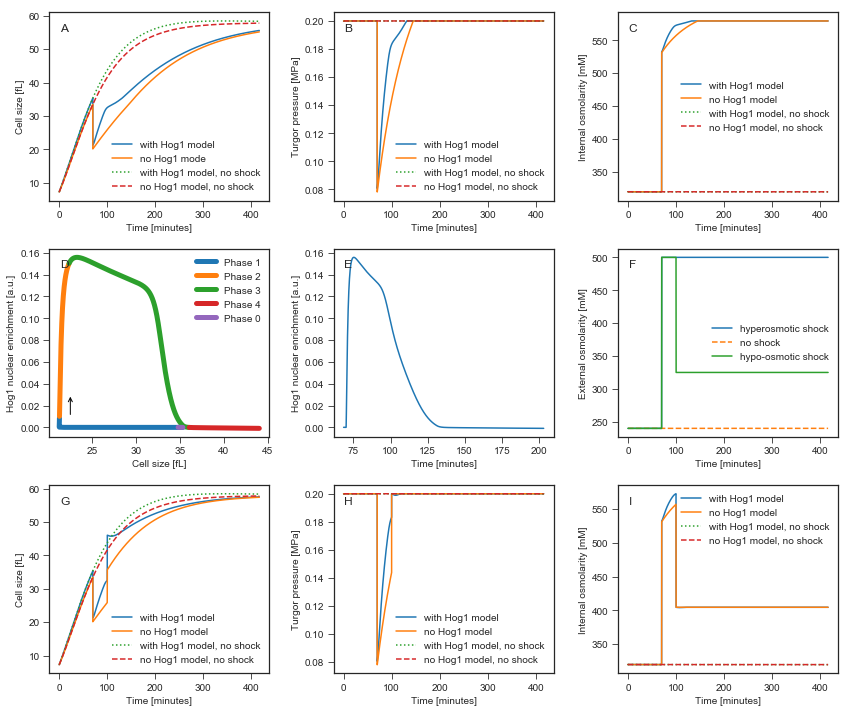

In [3]:
def apply_param_dict_to_model(model,param_dict):
    for param in param_dict.keys():
        if param_dict[param] is not None: # do not change parameters marked with value==None.
            print param_dict[param]
            model[param] = param_dict[param]
    return model


#from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

#def figure_numbering(text): 
#    artist = AnchoredText(text,
#                      prop=dict(size=12), frameon=False,
#                      loc=2, #  2: upper left 
#                      )
#    return artist
    
gs = gridspec.GridSpec(3, 3)

volume_and_hog_model = te.loadAntimonyModel("volume_and_hog.txt")
volume_model = te.loadAntimonyModel("volume_reference_radius.txt")

volume_and_hog_model.integrator.relative_tolerance = 1e-10
volume_model.integrator.relative_tolerance = 1e-10

volume_and_hog_model_species=['time','vol_V_tot_fl', '[hog_Glyc_in]','[vol_c_i]', 'hog_Glyc_in','vol_c_i', 'hog_totalHog1PP','hog_n_totalHog1', 'hog_Hog1PPn', 'hog_Hog1PPc','hog_Hog1n', 'hog_Hog1c', '[hog_Hog1PPn]', '[hog_Hog1PPc]','[hog_Hog1n]', '[hog_Hog1c]', 'vol_pi_t', 'vol_pi_i']
volume_model_species=['time','V_tot_fl','R_ref','V_ref','r_os','r_b', '[c_e]','[c_i]','c_i', 'pi_t', 'pi_i']

end_time = 25000

no_shock = volume_model['shock_set_c_e']
no_hyposhock = volume_model['hyposhock_set_c_e']
shock_event_time = 70*60 #volume_model['shock_event_time'] 
hyposhock_event_time = 100*60 #volume_model['hyposhock_event_time']

shock_add = 260 # raise external osmolarity by +260mM to 500mM overall.
shock = no_shock + shock_add
hyposhock = no_hyposhock + shock_add 

volume_hog_param_dict = {'vol_k_nutrient': None,
                         'vol_k_deg': None,
                         'vol_shock_event_time': shock_event_time,
                         'vol_hyposhock_event_time': hyposhock_event_time,
                         'vol_shock_set_c_e': shock,
                         'vol_hyposhock_set_c_e': hyposhock
                    }

volume_param_dict = {'k_nutrient': None,
                     'k_deg': None,
                     'shock_event_time': shock_event_time,
                     'hyposhock_event_time': hyposhock_event_time,
                     'shock_set_c_e': shock,
                     'hyposhock_set_c_e': hyposhock
                    }


volume_and_hog_model = apply_param_dict_to_model(volume_and_hog_model,volume_hog_param_dict)
volume_model = apply_param_dict_to_model(volume_model,volume_param_dict)

# Initiate with a small ~5-10 fL, for HOG model - Discussion! :
r_b_0 = 3 * volume_model['r_b_0'] 
r_os_0 = 3 * volume_model['r_os_0']
c_i = volume_model['[c_i]']

volume_model['r_b_0'] = r_b_0
volume_model['r_os_0'] = r_os_0

volume_and_hog_model['vol_r_b_0'] = r_b_0
volume_and_hog_model['vol_r_os_0'] = r_os_0


# To re-evaluate inital values according to new compartment size:
volume_model.reset()
volume_model['[c_i]'] = c_i # To keep c_i steady-state: reset to inital value, otherwise concentrations are recalulated to updated compartment size automatically.
volume_and_hog_model.reset() 

volume_and_hog_sim=volume_and_hog_model.simulate(1, end_time, end_time, selections = volume_and_hog_model_species)
volume_sim=volume_model.simulate(1, end_time, end_time, selections = volume_model_species)

############################
# For comparison with no-shock: 
volume_and_hog_model['vol_shock_set_c_e']=no_shock
volume_and_hog_model['vol_hyposhock_set_c_e']=no_hyposhock
volume_model['shock_set_c_e']=no_shock
volume_model['hyposhock_set_c_e']=no_hyposhock
volume_and_hog_model.reset()
volume_model.reset()
volume_model['[c_i]'] = c_i

volume_and_hog_sim_no_shock=volume_and_hog_model.simulate(1, end_time, end_time, selections = volume_and_hog_model_species)
volume_sim_no_shock=volume_model.simulate(1, end_time, end_time, selections = volume_model_species)
############################


plt.figure(figsize=(12,10))




ax = plt.subplot(gs[0,0])
plt.gca().add_artist(figure_numbering('A'))
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_V_tot_fl'],label = 'with Hog1 model')
plt.plot(volume_sim['time']/60,volume_sim['V_tot_fl'],label = 'no Hog1 mode')
plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['vol_V_tot_fl'],':',label = 'with Hog1 model, no shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['V_tot_fl'],'--',label = 'no Hog1 model, no shock')
plt.ylabel('Cell size [fL]')
plt.xlabel('Time [minutes]')
plt.legend()

#plt.subplot(3,3,3)
plt.subplot(gs[0,1])
plt.gca().add_artist(figure_numbering('B'))
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_pi_t']/1e6,label = 'with Hog1 model')
plt.plot(volume_sim['time']/60,volume_sim['pi_t']/1e6,label = 'no Hog1 model')
plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['vol_pi_t']/1e6,':',label = 'with Hog1 model, no shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['pi_t']/1e6,'--',label = 'no Hog1 model, no shock')
#plt.xlim(90,200)
plt.ylabel('Turgor pressure [MPa]')
plt.xlabel('Time [minutes]')
plt.legend()

plt.subplot(gs[0,2])
plt.gca().add_artist(figure_numbering('C'))
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['[vol_c_i]'] + volume_and_hog_sim['[hog_Glyc_in]'],label = 'with Hog1 model')
plt.plot(volume_sim['time']/60,volume_sim['[c_i]'],label = 'no Hog1 model')
plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['[vol_c_i]'] + volume_and_hog_sim_no_shock['[hog_Glyc_in]'],':',label = 'with Hog1 model, no shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['[c_i]'],'--',label = 'no Hog1 model, no shock')
plt.ylabel('Internal osmolarity [mM]')
plt.xlabel('Time [minutes]')
plt.legend()



shock_event_time = int(volume_model['shock_event_time'])
#plt.subplot(3,1,2)
plt.subplot(gs[1,0])
plt.gca().add_artist(figure_numbering('D'))
total_Hog1 = (volume_and_hog_sim['hog_Hog1PPn'] + volume_and_hog_sim['hog_Hog1PPc'] + volume_and_hog_sim['hog_Hog1n'] + volume_and_hog_sim['hog_Hog1c'])
Rt = (volume_and_hog_sim['[hog_Hog1PPn]']+volume_and_hog_sim['[hog_Hog1n]']) * 1e-15 * volume_and_hog_sim['vol_V_tot_fl']/total_Hog1
enrichment = Rt
enrichment = (Rt/(Rt[shock_event_time-1])) - 1  #
phase_4 = [shock_event_time+4000,shock_event_time+8000]
phase_3 = [shock_event_time+200,shock_event_time+4000]
phase_2 = [shock_event_time+10,shock_event_time+200]
phase_1 = [shock_event_time-1,shock_event_time+10]
phase_0 = [shock_event_time-100,shock_event_time]
thickness = 5 # line thickness in phase plot
#plt.plot(volume_and_hog_sim['vol_V_tot_fl'][7100:250*60],volume_and_hog_sim['hog_totalHog1PP'][7100:250*60],label = 'hog_Hog1PPn',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_1[0]:phase_1[1]],enrichment[phase_1[0]:phase_1[1]],label = 'Phase 1',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_2[0]:phase_2[1]],enrichment[phase_2[0]:phase_2[1]],label = 'Phase 2',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_3[0]:phase_3[1]],enrichment[phase_3[0]:phase_3[1]],label = 'Phase 3',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_4[0]:phase_4[1]],enrichment[phase_4[0]:phase_4[1]],label = 'Phase 4',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_0[0]:phase_0[1]],enrichment[phase_0[0]:phase_0[1]],label = 'Phase 0',linewidth=thickness)
plt.annotate('', xy=(22.5, .03), xycoords="data",xytext=(22.5,0.01),arrowprops=dict(arrowstyle="->"))
plt.ylabel('Hog1 nuclear enrichment [a.u.]')
plt.xlabel('Cell size [fL]')
plt.legend()

plt.subplot(gs[1,1])
plt.gca().add_artist(figure_numbering('E'))
plt.plot(volume_and_hog_sim['time'][phase_0[0]:phase_4[1]]/60,enrichment[phase_0[0]:phase_4[1]])
plt.ylabel('Hog1 nuclear enrichment [a.u.]')
plt.xlabel('Time [minutes]')
plt.legend()

plt.subplot(gs[1,2])
plt.gca().add_artist(figure_numbering('F'))
plt.plot(volume_sim['time']/60,volume_sim['[c_e]'],label = 'hyperosmotic shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['[c_e]'],'--',label = 'no shock' )
plt.ylabel('External osmolarity [mM]')
plt.xlabel('Time [minutes]')
plt.legend()

#plt.subplot(gs[1,1])
#plt.gca().add_artist(figure_numbering('D'))
#plt.plot(volume_sim['time']/60,volume_sim['V_tot_fl'],label = 'Cell size')
#plt.plot(volume_sim['time']/60,volume_sim['V_ref'],label = 'Reference volume')
#plt.ylabel('Volume [fL]')
#plt.xlabel('Time [minutes]')
#plt.legend()


###########################
# Hypo-osmotic shock:

volume_model.reset()
volume_model['[c_i]'] = c_i
volume_and_hog_model.reset()

shock_sub = 85

shock = no_shock + shock_add
hyposhock = no_hyposhock + shock_sub

volume_hog_param_dict = {'vol_k_nutrient': None,
                         'vol_k_deg': None,
                         'vol_shock_event_time': None,
                         'vol_hyposhock_event_time': None,
                         'vol_shock_set_c_e': shock,
                         'vol_hyposhock_set_c_e': hyposhock
                    }

volume_param_dict = {'k_nutrient': None,
                     'k_deg': None,
                     'shock_event_time': None,
                     'hyposhock_event_time': None,
                     'shock_set_c_e': shock,
                     'hyposhock_set_c_e': hyposhock
                    }


volume_and_hog_model = apply_param_dict_to_model(volume_and_hog_model,volume_hog_param_dict)
volume_model = apply_param_dict_to_model(volume_model,volume_param_dict)

volume_and_hog_sim=volume_and_hog_model.simulate(1, end_time, end_time, selections = volume_and_hog_model_species)
volume_sim=volume_model.simulate(1, end_time, end_time, selections = volume_model_species)




#plt.subplot(3,3,8)
plt.subplot(gs[2,0])
plt.gca().add_artist(figure_numbering('G'))
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_V_tot_fl'],label = 'with Hog1 model')
plt.plot(volume_sim['time']/60,volume_sim['V_tot_fl'],label = 'no Hog1 model')
plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['vol_V_tot_fl'],':',label = 'with Hog1 model, no shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['V_tot_fl'],'--',label = 'no Hog1 model, no shock')
plt.ylabel('Cell size [fL]')
plt.xlabel('Time [minutes]')
#plt.xlim(90,200)
plt.legend()

plt.subplot(gs[2,1])
plt.gca().add_artist(figure_numbering('H'))
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_pi_t']/1e6,label = 'with Hog1 model')
plt.plot(volume_sim['time']/60,volume_sim['pi_t']/1e6,label = 'no Hog1 model')
plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['vol_pi_t']/1e6,':',label = 'with Hog1 model, no shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['pi_t']/1e6,'--',label = 'no Hog1 model, no shock')
plt.ylabel('Turgor pressure [MPa]')
plt.xlabel('Time [minutes]')
plt.legend()

plt.subplot(gs[2,2])
plt.gca().add_artist(figure_numbering('I'))
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['[vol_c_i]'] + volume_and_hog_sim['[hog_Glyc_in]'],label = 'with Hog1 model')
plt.plot(volume_sim['time']/60,volume_sim['[c_i]'],label = 'no Hog1 model')
plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['[vol_c_i]'] + volume_and_hog_sim_no_shock['[hog_Glyc_in]'],':',label = 'with Hog1 model, no shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['[c_i]'],'--',label = 'no Hog1 model, no shock')
plt.ylabel('Internal osmolarity [mM]')
plt.xlabel('Time [minutes]')
plt.legend()

plt.subplot(gs[1,2])
#plt.gca().add_artist(figure_numbering('A'))
plt.plot(volume_sim['time']/60,volume_sim['[c_e]'],label = 'hypo-osmotic shock')
plt.ylabel('External osmolarity [mM]')
plt.legend()

plt.tight_layout()
#plt.savefig('figures/volume_and_hog_shocks_supplement.png',dpi=300)
#plt.savefig('figures/volume_and_hog_shocks_supplement.eps')
    
    

500.0
6000
4200
500.0
500.0
500.0
4200
6000
325.0
500.0
500.0
325.0


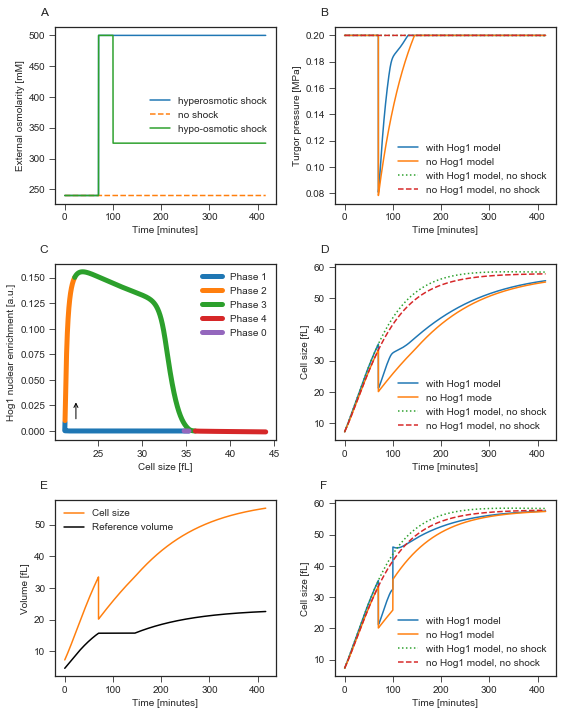

In [17]:
def apply_param_dict_to_model(model,param_dict):
    for param in param_dict.keys():
        if param_dict[param] is not None: # do not change parameters marked with value==None.
            print param_dict[param]
            model[param] = param_dict[param]
    return model

#from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

#def figure_numbering(text): 
#    artist = AnchoredText(text,
#                      prop=dict(size=12), frameon=False,
#                      loc=2, #  2: upper left 
#                      )
#    return artist
    
gs = gridspec.GridSpec(3, 2)

volume_and_hog_model = te.loadAntimonyModel("volume_and_hog.txt")
volume_model = te.loadAntimonyModel("volume_reference_radius.txt")

volume_and_hog_model.integrator.relative_tolerance = 1e-10
volume_model.integrator.relative_tolerance = 1e-10

volume_and_hog_model_species=['time','vol_V_tot_fl', '[hog_Glyc_in]','[vol_c_i]', 'hog_Glyc_in','vol_c_i', 'hog_totalHog1PP','hog_n_totalHog1', 'hog_Hog1PPn', 'hog_Hog1PPc','hog_Hog1n', 'hog_Hog1c', '[hog_Hog1PPn]', '[hog_Hog1PPc]','[hog_Hog1n]', '[hog_Hog1c]', 'vol_pi_t', 'vol_pi_i']
volume_model_species=['time','V_tot_fl','R_ref','V_ref','r_os','r_b', '[c_e]','[c_i]','c_i', 'pi_t', 'pi_i']

end_time = 25000

no_shock = volume_model['shock_set_c_e']
no_hyposhock = volume_model['hyposhock_set_c_e']
shock_event_time = 70*60 #volume_model['shock_event_time'] 
hyposhock_event_time = (70+30)*60 #volume_model['hyposhock_event_time']

shock_add = 260 # raise external osmolarity by +260mM to 500mM overall.
shock = no_shock + shock_add
hyposhock = no_hyposhock + shock_add 

volume_hog_param_dict = {'vol_k_nutrient': None,
                         'vol_k_deg': None,
                         'vol_shock_event_time': shock_event_time,
                         'vol_hyposhock_event_time': hyposhock_event_time,
                         'vol_shock_set_c_e': shock,
                         'vol_hyposhock_set_c_e': hyposhock
                    }

volume_param_dict = {'k_nutrient': None,
                     'k_deg': None,
                     'shock_event_time': shock_event_time,
                     'hyposhock_event_time': hyposhock_event_time,
                     'shock_set_c_e': shock,
                     'hyposhock_set_c_e': hyposhock
                    }


volume_and_hog_model = apply_param_dict_to_model(volume_and_hog_model,volume_hog_param_dict)
volume_model = apply_param_dict_to_model(volume_model,volume_param_dict)

# Initiate with a small ~5-10 fL, for HOG model - Discussion! :
r_b_0 = 3 * volume_model['r_b_0'] 
r_os_0 = 3 * volume_model['r_os_0']
c_i = volume_model['[c_i]']

volume_model['r_b_0'] = r_b_0
volume_model['r_os_0'] = r_os_0

volume_and_hog_model['vol_r_b_0'] = r_b_0
volume_and_hog_model['vol_r_os_0'] = r_os_0


# To re-evaluate inital values according to new compartment size:
volume_model.reset()
volume_model['[c_i]'] = c_i # To keep c_i steady-state: reset to inital value, otherwise concentrations are recalulated to updated compartment size automatically.
volume_and_hog_model.reset() 

volume_and_hog_sim=volume_and_hog_model.simulate(1, end_time, end_time, selections = volume_and_hog_model_species)
volume_sim=volume_model.simulate(1, end_time, end_time, selections = volume_model_species)

############################
# For comparison with no-shock: 
volume_and_hog_model['vol_shock_set_c_e']=no_shock
volume_and_hog_model['vol_hyposhock_set_c_e']=no_hyposhock
volume_model['shock_set_c_e']=no_shock
volume_model['hyposhock_set_c_e']=no_hyposhock
volume_and_hog_model.reset()
volume_model.reset()
volume_model['[c_i]'] = c_i

volume_and_hog_sim_no_shock=volume_and_hog_model.simulate(1, end_time, end_time, selections = volume_and_hog_model_species)
volume_sim_no_shock=volume_model.simulate(1, end_time, end_time, selections = volume_model_species)
############################

plt.figure(figsize=(8,10))

#plt.subplot(gs[0,0])
#plt.gca().add_artist(FT.figure_numbering('A'))
#plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['[vol_c_i]'] + volume_and_hog_sim['[hog_Glyc_in]'],label = 'with Hog1 model')
#plt.plot(volume_sim['time']/60,volume_sim['[c_i]'],label = 'no Hog1 model')
#plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['[vol_c_i]'] + volume_and_hog_sim_no_shock['[hog_Glyc_in]'],':',label = 'with Hog1 model, no shock')
#plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['[c_i]'],'--',label = 'no Hog1 model, no shock')
#plt.ylabel('Internal osmolarity [mM]')
#plt.xlabel('Time [minutes]')
#plt.legend()

plt.subplot(gs[1,1])
plt.gca().add_artist(FT.figure_numbering('D'))
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_V_tot_fl'],label = 'with Hog1 model')
plt.plot(volume_sim['time']/60,volume_sim['V_tot_fl'],label = 'no Hog1 mode')
plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['vol_V_tot_fl'],':',label = 'with Hog1 model, no shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['V_tot_fl'],'--',label = 'no Hog1 model, no shock')
plt.ylabel('Cell size [fL]')
plt.xlabel('Time [minutes]')
plt.legend()

#plt.subplot(3,3,3)
plt.subplot(gs[0,1])
plt.gca().add_artist(FT.figure_numbering('B'))
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_pi_t']/1e6,label = 'with Hog1 model')
plt.plot(volume_sim['time']/60,volume_sim['pi_t']/1e6,label = 'no Hog1 model')
plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['vol_pi_t']/1e6,':',label = 'with Hog1 model, no shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['pi_t']/1e6,'--',label = 'no Hog1 model, no shock')
#plt.xlim(90,200)
plt.ylabel('Turgor pressure [MPa]')
plt.xlabel('Time [minutes]')
plt.legend()


shock_event_time = int(volume_model['shock_event_time'])
#plt.subplot(3,1,2)
plt.subplot(gs[1,0])
plt.gca().add_artist(FT.figure_numbering('C'))
total_Hog1 = (volume_and_hog_sim['hog_Hog1PPn'] + volume_and_hog_sim['hog_Hog1PPc'] + volume_and_hog_sim['hog_Hog1n'] + volume_and_hog_sim['hog_Hog1c'])
Rt = (volume_and_hog_sim['[hog_Hog1PPn]']+volume_and_hog_sim['[hog_Hog1n]']) * 1e-15 * volume_and_hog_sim['vol_V_tot_fl']/total_Hog1
enrichment = Rt
enrichment = (Rt/(Rt[shock_event_time-1])) - 1  #
phase_4 = [shock_event_time+4000,shock_event_time+8000]
phase_3 = [shock_event_time+200,shock_event_time+4000]
phase_2 = [shock_event_time+10,shock_event_time+200]
phase_1 = [shock_event_time-1,shock_event_time+10]
phase_0 = [shock_event_time-100,shock_event_time]
thickness = 5 # line thickness in phase plot
#plt.plot(volume_and_hog_sim['vol_V_tot_fl'][7100:250*60],volume_and_hog_sim['hog_totalHog1PP'][7100:250*60],label = 'hog_Hog1PPn',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_1[0]:phase_1[1]],enrichment[phase_1[0]:phase_1[1]],label = 'Phase 1',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_2[0]:phase_2[1]],enrichment[phase_2[0]:phase_2[1]],label = 'Phase 2',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_3[0]:phase_3[1]],enrichment[phase_3[0]:phase_3[1]],label = 'Phase 3',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_4[0]:phase_4[1]],enrichment[phase_4[0]:phase_4[1]],label = 'Phase 4',linewidth=thickness)
plt.plot(volume_and_hog_sim['vol_V_tot_fl'][phase_0[0]:phase_0[1]],enrichment[phase_0[0]:phase_0[1]],label = 'Phase 0',linewidth=thickness)
plt.annotate('', xy=(22.5, .03), xycoords="data",xytext=(22.5,0.01),arrowprops=dict(arrowstyle="->"))
plt.ylabel('Hog1 nuclear enrichment [a.u.]')
plt.xlabel('Cell size [fL]')
plt.legend()

plt.subplot(gs[0,0])
plt.gca().add_artist(FT.figure_numbering('A'))
plt.plot(volume_sim['time']/60,volume_sim['[c_e]'],label = 'hyperosmotic shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['[c_e]'],'--',label = 'no shock' )
plt.ylabel('External osmolarity [mM]')
plt.xlabel('Time [minutes]')
plt.legend()

plt.subplot(gs[2,0])
plt.gca().add_artist(FT.figure_numbering('E'))
current_palette = sns.color_palette()
plt.plot(volume_sim['time']/60,volume_sim['V_tot_fl'],label = 'Cell size',color = current_palette[1])
plt.plot(volume_sim['time']/60,volume_sim['V_ref'],label = 'Reference volume', color = 'black')
plt.ylabel('Volume [fL]')
plt.xlabel('Time [minutes]')
plt.legend()


###########################
# Hypo-osmotic shock:

volume_model.reset()
volume_model['[c_i]'] = c_i
volume_and_hog_model.reset()

shock_sub = 85

shock = no_shock + shock_add
hyposhock = no_hyposhock + shock_sub

volume_hog_param_dict = {'vol_k_nutrient': None,
                         'vol_k_deg': None,
                         'vol_shock_event_time': None,
                         'vol_hyposhock_event_time': None,
                         'vol_shock_set_c_e': shock,
                         'vol_hyposhock_set_c_e': hyposhock
                    }

volume_param_dict = {'k_nutrient': None,
                     'k_deg': None,
                     'shock_event_time': None,
                     'hyposhock_event_time': None,
                     'shock_set_c_e': shock,
                     'hyposhock_set_c_e': hyposhock
                    }


volume_and_hog_model = apply_param_dict_to_model(volume_and_hog_model,volume_hog_param_dict)
volume_model = apply_param_dict_to_model(volume_model,volume_param_dict)

volume_and_hog_sim=volume_and_hog_model.simulate(1, end_time, end_time, selections = volume_and_hog_model_species)
volume_sim=volume_model.simulate(1, end_time, end_time, selections = volume_model_species)



#plt.subplot(gs[2,0])
#plt.gca().add_artist(figure_numbering('F'))
#plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['[vol_c_i]'] + volume_and_hog_sim['[hog_Glyc_in]'],label = 'with Hog1 model')
#plt.plot(volume_sim['time']/60,volume_sim['[c_i]'],label = 'no Hog1 model')
#plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['[vol_c_i]'] + volume_and_hog_sim_no_shock['[hog_Glyc_in]'],':',label = 'with Hog1 model, no shock')
#plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['[c_i]'],'--',label = 'no Hog1 model, no shock')
#plt.ylabel('Internal osmolarity [mM]')
#plt.xlabel('Time [minutes]')
#plt.legend()

#plt.subplot(3,3,8)
plt.subplot(gs[2,1])
plt.gca().add_artist(FT.figure_numbering('F'))
plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_V_tot_fl'],label = 'with Hog1 model')
plt.plot(volume_sim['time']/60,volume_sim['V_tot_fl'],label = 'no Hog1 model')
plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['vol_V_tot_fl'],':',label = 'with Hog1 model, no shock')
plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['V_tot_fl'],'--',label = 'no Hog1 model, no shock')
plt.ylabel('Cell size [fL]')
plt.xlabel('Time [minutes]')
#plt.xlim(90,200)
plt.legend()

#plt.subplot(gs[2,2])
#plt.gca().add_artist(figure_numbering('H'))
#plt.plot(volume_and_hog_sim['time']/60,volume_and_hog_sim['vol_pi_t']/1e6,label = 'with Hog1 model')
#plt.plot(volume_sim['time']/60,volume_sim['pi_t']/1e6,label = 'no Hog1 model')
#plt.plot(volume_and_hog_sim_no_shock['time']/60,volume_and_hog_sim_no_shock['vol_pi_t']/1e6,':',label = 'with Hog1 model, no shock')
#plt.plot(volume_sim_no_shock['time']/60,volume_sim_no_shock['pi_t']/1e6,'--',label = 'no Hog1 model, no shock')
#plt.ylabel('Turgor pressure [MPa]')
#plt.xlabel('Time [minutes]')
#plt.legend()

plt.subplot(gs[0,0])
#plt.gca().add_artist(figure_numbering('A'))
plt.plot(volume_sim['time']/60,volume_sim['[c_e]'],label = 'hypo-osmotic shock')
plt.ylabel('External osmolarity [mM]')
plt.legend()

plt.tight_layout()
#plt.savefig('figures/volume_and_hog_shocks.png',dpi=300)
#plt.savefig('figures/volume_and_hog_shocks.eps')
    

620.0
6000
4200
620.0
620.0
620.0
4200
6000


<function matplotlib.pyplot.show>

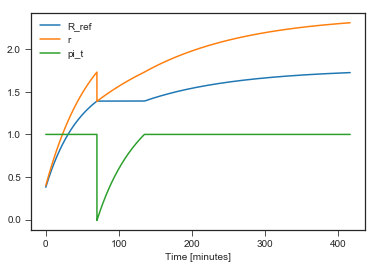

In [78]:
volume_and_hog_model = te.loadAntimonyModel("volume_and_hog.txt")
volume_model = te.loadAntimonyModel("volume_reference_radius.txt")

volume_and_hog_model.integrator.relative_tolerance = 1e-10
volume_model.integrator.relative_tolerance = 1e-10

volume_and_hog_model_species=['time','vol_V_tot_fl', '[hog_Glyc_in]','[vol_c_i]', 'hog_Glyc_in','vol_c_i', 'hog_totalHog1PP','hog_n_totalHog1', 'hog_Hog1PPn', 'hog_Hog1PPc','hog_Hog1n', 'hog_Hog1c', '[hog_Hog1PPn]', '[hog_Hog1PPc]','[hog_Hog1n]', '[hog_Hog1c]', 'vol_pi_t', 'vol_pi_i']
volume_model_species=['time','V_tot_fl','R_ref','r_os','r_b', '[c_e]','[c_i]','c_i', 'pi_t', 'pi_i']

end_time = 25000

#k_adjust = 1.27
#k_nutrient = 2. * 1e-16 # mM/s/um^2   
#k_deg = k_adjust * k_nutrient # mM/s/um^2   

no_shock = volume_model['shock_set_c_e']
no_hyposhock = volume_model['hyposhock_set_c_e']
shock_event_time = 70*60 #volume_model['shock_event_time']
hyposhock_event_time = 100*60 #volume_model['hyposhock_event_time']


#shock = 240+no_shock
#hyposhock = 240+no_hyposhock
shock = 380+no_shock
hyposhock = 380+no_hyposhock
volume_hog_param_dict = {'vol_k_nutrient': None,
                         'vol_k_deg': None,
                         'vol_shock_event_time': shock_event_time,
                         'vol_hyposhock_event_time': hyposhock_event_time,
                         'vol_shock_set_c_e': shock,
                         'vol_hyposhock_set_c_e': hyposhock
                    }

volume_param_dict = {'k_nutrient': None,
                     'k_deg': None,
                     'shock_event_time': shock_event_time,
                     'hyposhock_event_time': hyposhock_event_time,
                     'shock_set_c_e': shock,
                     'hyposhock_set_c_e': hyposhock
                    }


volume_and_hog_model = apply_param_dict_to_model(volume_and_hog_model,volume_hog_param_dict)
volume_model = apply_param_dict_to_model(volume_model,volume_param_dict)

volume_and_hog_sim=volume_and_hog_model.simulate(1, end_time, end_time, selections = volume_and_hog_model_species)
volume_sim=volume_model.simulate(1, end_time, end_time, selections = volume_model_species)

plt.plot(volume_sim['time']/60,volume_sim['R_ref'],label = 'R_ref')
plt.plot(volume_sim['time']/60,volume_sim['r_os'] + volume_sim['r_b'],label = 'r')
#plt.plot(volume_sim['time']/60,4/3*np.pi* (volume_sim['R_ref'] )**3 ,label = 'reference cell size')
#plt.plot(volume_sim['time']/60,4/3*np.pi* ( volume_sim['r_os'] + volume_sim['r_b'] )**3 ,label = 'cell size')
plt.plot(volume_sim['time']/60,volume_sim['pi_t']/np.max(volume_sim['pi_t']),label = 'pi_t')

#plt.ylabel('Volume [fL]')
plt.xlabel('Time [minutes]')
plt.legend()

plt.show

#print volume_sim

